# test_donor_assign

In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
!pip install line_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.8 MB/s eta 0:00:00


## Line Profile

### Load test region data

In [2]:
import os
output_dir = 'data'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
BAM_PATH = "gs://nnfc-hgrm-output/10x-scRNA/2021-jones-villages/20230612-cellranger/hep_D2_CIRM12_1/outs/possorted_genome_bam.bam"
region = "chr1:0-20267008 bytes:3189-1303195899"
chrom_region, file_region = region.split(' bytes:')
VCF_PATH = "gs://landerlab-vcfs/village_WGS_vcfs/merged_WGS_spikeins.vcf.gz"
end_pos = int(chrom_region.split('-')[-1])

In [5]:
! chmod +x load_test_data.sh

In [28]:
! ./load_test_data.sh $VCF_PATH $BAM_PATH $file_region "chr1" 20267008 $output_dir

VCF_PATH=gs://landerlab-vcfs/village_WGS_vcfs/merged_WGS_spikeins.vcf.gz, BAM_PATH=gs://nnfc-hgrm-output/10x-scRNA/2021-jones-villages/20230612-cellranger/hep_D2_CIRM12_1/outs/possorted_genome_bam.bam, file_region=3189-1303195899, CHROM=chr1, POS=20267008, output_dir=data
[W::bam_hdr_read] EOF marker is absent. The input is probably truncated
Making region vcf file
gunzip: error writing to output: Broken pipe
gunzip: error writing to output: Broken pipe


### Run count_reads_on_variants.py

In [38]:
! python -u donor_assignment/count_reads_on_variants.py data/region.bam data/region.vcf.gz  "--umi-tag=UB"

donor_assignment/count_reads_on_variants.py:24: UserWarning: no BGZF EOF marker; file may be truncated
  bamfile = pysam.AlignmentFile(self.bam_path, mode="rb", ignore_truncation=True)
[W::bam_hdr_read] EOF marker is absent. The input is probably truncated


In [6]:
! gunzip -c results.tsv.gz | wc -l

 3233632


### Run likelihood_per_region.py

In [4]:
donor_list_file="gs://landerlab-vcfs/village_WGS_vcfs/donor_list.txt"
likelihood_method="our_method"
whitelist="gs://nnfc-hgrm-output/10x-scRNA/2021-jones-villages/20230612-cellranger/hep_D2_CIRM12_1/outs/filtered_feature_bc_matrix/barcodes.tsv.gz"

In [21]:
! gunzip -c results.tsv.gz | head -n1000 > head.results.tsv

gunzip: error writing to output: Broken pipe
gunzip: results.tsv.gz: uncompress failed


In [22]:
! gzip head.results.tsv

In [5]:
donors = [ln.strip() for ln in open("donor_list.txt")]

In [21]:
bcftools_proc = subprocess.Popen(f"bcftools query -s {','.join(donors)} -f %CHROM\t%POS\t%TYPE\t%REF\t%ALT[\t%GT]\n data/region.vcf.gz".split(' '),
                                     stdout=subprocess.PIPE)

genotypes = pd.read_table(bcftools_proc.stdout, header=None,
                          names="chrom pos type REF ALT".split() + donors)
genotypes = genotypes.sort_values("chrom pos".split())
genotypes = genotypes.set_index(['pos'])

In [23]:
import numpy as np
donor_alt_cts = genotypes[donors].applymap(lambda x: x.count('1'))
donor_missing = genotypes[donors].applymap(lambda x: '.' in x).astype(int).replace({1: np.nan})
fill_donor_alt_cts = donor_alt_cts + donor_missing # possible 1/.?

In [29]:
donor_missing_snps_num_s = fill_donor_alt_cts.isna().sum()

# Testing our method

## New version

In [9]:
! kernprof -l ../donor_assignment/likelihood_per_region_combined.py results.tsv.gz "donor_list.txt" data/region.vcf.gz $chrom_region $likelihood_method $whitelist 0.1 --error_by_base


Read data for 2291713 UMIs.
Read genotypes for 42082 SNPs and 312 donors
Genotypes to counts done.
Unique CBC chunks: 100%|████████████████████████| 73/73 [24:13<00:00, 19.90s/it]
Done.
Wrote profile results to likelihood_per_region_combined.py.lprof
Inspect results with:
python -m line_profiler -rmt "likelihood_per_region_combined.py.lprof"


In [10]:
! python -m line_profiler "likelihood_per_region_combined.py.lprof"

Timer unit: 1e-06 s

Total time: 56.8113 s
File: ../donor_assignment/likelihood_per_region_combined.py
Function: new_generate_barcode_lls at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           @profile
    13                                           def new_generate_barcode_lls(barcode_reads, donors, fill_donor_alt_cts, error_rate):
    14                                           
    15                                               # Probability of neither REF or ALT base
    16        73        184.0      2.5      0.0      prob_neither = 2 * error_rate / 3 / len(donors)
    17                                               
    18                                               # Donor population probability adjustment
    19        73      70584.0    966.9      0.1      barcode_reads['score_donor_ref'] = barcode_reads.ref_prob * 2 / barcode_reads.adj_num_donor_ref_alleles + prob_neither
    20        73      69917.0

## original version

In [11]:
! kernprof -l ../donor_assignment/likelihood_per_region.py results.tsv.gz "donor_list.txt" data/region.vcf.gz $chrom_region $likelihood_method $whitelist

Read data for 2291713 UMIs.
Read genotypes for 42082 SNPs and 312 donors
Genotypes to counts done.
35591
35091
34591
34091
33591
33091
32591
32091
31591
31091
30591
30091
29591
29091
28591
28091
27591
27091
26591
26091
25591
25091
24591
24091
23591
23091
22591
22091
21591
21091
20591
20091
19591
19091
18591
18091
17591
17091
16591
16091
15591
15091
14591
14091
13591
13091
12591
12091
11591
11091
10591
10091
9591
9091
8591
8091
7591
7091
6591
6091
5591
5091
4591
4091
3591
3091
2591
2091
1591
1091
591
91
0
Done.
Wrote profile results to likelihood_per_region.py.lprof
Inspect results with:
python -m line_profiler -rmt "likelihood_per_region.py.lprof"


In [12]:
! python -m line_profiler "likelihood_per_region.py.lprof"

Timer unit: 1e-06 s

Total time: 256.424 s
File: ../donor_assignment/likelihood_per_region.py
Function: generate_barcode_lls at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           @profile
    12                                           def generate_barcode_lls(barcode_pos_reads, genotypes, donors, num_donors,
    13                                                                    P_donor_given_ref, P_donor_given_alt, simplified_region_name):
    14                                               """ Gather loglikelihood a cell came from a donor"""
    15        73      52334.0    716.9      0.0      barcode_pos_reads.reset_index('pos', inplace=True)
    16                                           
    17        73         35.0      0.5      0.0      temp_probs = 0
    18       365        369.0      1.0      0.0      for base in 'ACGT':
    19                                                   # Indicator vector of s

## Compare results

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
import subprocess

In [15]:
new_ours_version_df = pd.read_csv('barcode_log_likelihood_chr1_0_20267008.our_method.combined.txt.gz', compression='gzip', sep='\t')
old_ours_version_df = pd.read_csv('barcode_log_likelihood_chr1_0_20267008.our_method.txt.gz', compression='gzip', sep='\t')

In [31]:
expanded_donor_missing_snps_num_df = pd.concat([donor_missing_snps_num_s for i in range(old_ours_version_df.shape[0])], axis=1)

Text(0, 0.5, 'New version')

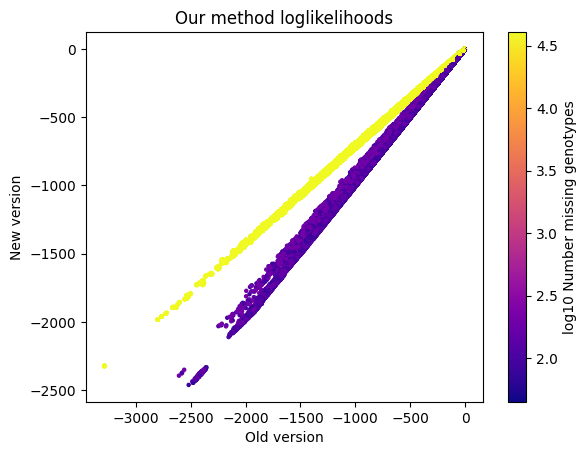

In [35]:
sc = plt.scatter(
    old_ours_version_df[donors].stack().values.tolist(), 
    new_ours_version_df[donors].stack().values.tolist(), 
    s=5,
    c=np.log10(expanded_donor_missing_snps_num_df.T[donors].stack().values).tolist(),
    cmap='plasma'
)
plt.colorbar(sc, label='log10 Number missing genotypes')
plt.title('Our method loglikelihoods')
plt.xlabel('Old version')
plt.ylabel('New version')

In [36]:
our_method_old_best_likelihood = old_ours_version_df[donors].max(axis=1)
our_method_new_best_likelihood = new_ours_version_df[donors].max(axis=1)

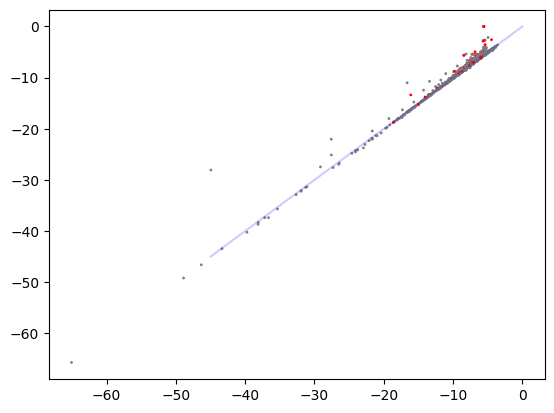

In [37]:
plt.scatter(
    our_method_old_best_likelihood.astype(float) / old_ours_version_df.num_umis.astype(float),
    our_method_new_best_likelihood.astype(float) / new_ours_version_df.num_umis.astype(float),
    s=1,
    c=(old_ours_version_df[donors].idxmax(axis=1) == new_ours_version_df[donors].idxmax(axis=1)).replace({True: 'gray', False: 'red'})
)
plt.plot([-45, 0], [-45, 0], c='blue', alpha=0.2)

# Testing new dropulation

## New version

In [39]:
! kernprof -l ../donor_assignment/likelihood_per_region_combined.py results.tsv.gz "donor_list.txt" data/region.vcf.gz $chrom_region dropulation $whitelist 0.001

Read data for 2291713 UMIs.
Read genotypes for 42082 SNPs and 312 donors
Genotypes to counts done.
Unique CBC chunks: 100%|████████████████████████| 73/73 [01:36<00:00,  1.32s/it]
Done.
Wrote profile results to likelihood_per_region_combined.py.lprof
Inspect results with:
python -m line_profiler -rmt "likelihood_per_region_combined.py.lprof"


In [40]:
! python -m line_profiler "likelihood_per_region_combined.py.lprof"

Timer unit: 1e-06 s

Total time: 0 s
File: ../donor_assignment/likelihood_per_region_combined.py
Function: new_generate_barcode_lls at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           @profile
    13                                           def new_generate_barcode_lls(barcode_reads, donors, fill_donor_alt_cts, error_rate, regularize_factor=0.95):
    14                                           
    15                                               # Probability of neither REF or ALT base
    16                                               prob_neither = 2 * error_rate / 3 / len(donors)
    17                                               
    18                                               # Donor population probability adjustment
    19                                               # score for donor given genotype = (ref_prob * num_ref_in_donor / cohort_num_ref) + (alt_prob * num_alt_in_donor / cohort_num_alt


## Compare to original scripts

In [41]:
! kernprof -l ../donor_assignment/likelihood_per_region.py results.tsv.gz "donor_list.txt" data/region.vcf.gz $chrom_region dropulation $whitelist

Read data for 2291713 UMIs.
Read genotypes for 42082 SNPs and 312 donors
Genotypes to counts done.
35591
35091
34591
34091
33591
33091
32591
32091
31591
31091
30591
30091
29591
29091
28591
28091
27591
27091
26591
26091
25591
25091
24591
24091
23591
23091
22591
22091
21591
21091
20591
20091
19591
19091
18591
18091
17591
17091
16591
16091
15591
15091
14591
14091
13591
13091
12591
12091
11591
11091
10591
10091
9591
9091
8591
8091
7591
7091
6591
6091
5591
5091
4591
4091
3591
3091
2591
2091
1591
1091
591
91
0
Done.
Wrote profile results to likelihood_per_region.py.lprof
Inspect results with:
python -m line_profiler -rmt "likelihood_per_region.py.lprof"


In [42]:
! python -m line_profiler "likelihood_per_region.py.lprof"

Timer unit: 1e-06 s

Total time: 0 s
File: ../donor_assignment/likelihood_per_region.py
Function: generate_barcode_lls at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           @profile
    12                                           def generate_barcode_lls(barcode_pos_reads, genotypes, donors, num_donors,
    13                                                                    P_donor_given_ref, P_donor_given_alt, simplified_region_name):
    14                                               """ Gather loglikelihood a cell came from a donor"""
    15                                               barcode_pos_reads.reset_index('pos', inplace=True)
    16                                           
    17                                               temp_probs = 0
    18                                               for base in 'ACGT':
    19                                                   # Indicator vector of shape [

## Compare

In [43]:
new_drop_version_df = pd.read_csv('barcode_log_likelihood_chr1_0_20267008.dropulation.combined.txt.gz', compression='gzip', sep='\t')
old_drop_version_df = pd.read_csv('barcode_log_likelihood_chr1_0_20267008.dropulation.txt.gz', compression='gzip', sep='\t')

In [44]:
expanded_donor_missing_snps_num_df = pd.concat([donor_missing_snps_num_s for i in range(old_drop_version_df.shape[0])], axis=1)

Text(0, 0.5, 'New version')

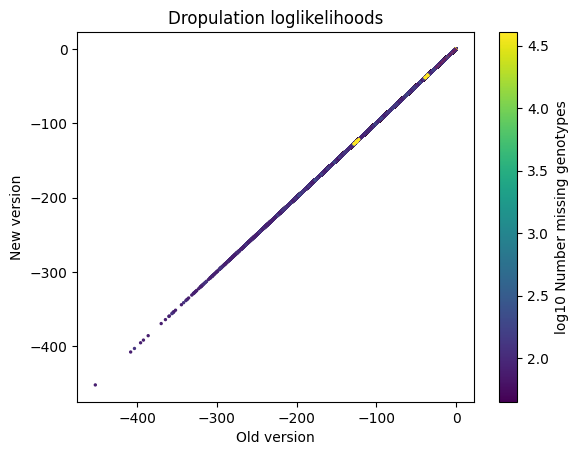

In [46]:
sc = plt.scatter(
    old_drop_version_df[donors].stack().values.tolist(), 
    new_drop_version_df[donors].stack().values.tolist(), 
    s=2, 
    c=np.log10(expanded_donor_missing_snps_num_df.T[donors].stack().values).tolist()
)
plt.colorbar(sc, label='log10 Number missing genotypes')
plt.plot([0, -25], [0, -25], 'r-', alpha=0.2)
plt.title('Dropulation loglikelihoods')
plt.xlabel('Old version')
plt.ylabel('New version')

In [ ]:
fig, ax = plt.subplots()
dropulation_new_best_likelihood = new_drop_version_df[donors].max(axis=1)
plt.hexbin(
    dropulation_new_best_likelihood.astype(float) / new_drop_version_df.num_umis.astype(float),
    new_drop_version_df.num_umis.astype(float), yscale='log', cmap='inferno', bins='log'
)
plt.colorbar(label='# of cells')
plt.xlabel('LogLik per UMI')
plt.ylabel('num UMIs')
plt.title('Old Log Likelihoods')
plt.axvline(-.165)

In [ ]:
fig, ax = plt.subplots()
dropulation_old_best_likelihood = old_drop_version_df[donors].max(axis=1)
plt.hexbin(
    dropulation_old_best_likelihood.astype(float) / old_drop_version_df.num_umis.astype(float),
    old_drop_version_df.num_umis.astype(float), yscale='log', cmap='inferno', bins='log'
)
plt.colorbar(label='# of cells')
plt.xlabel('LogLik per UMI')
plt.ylabel('num UMIs')
plt.title('Old Log Likelihoods')
plt.axvline(-.165)

In [ ]:
plt.scatter(
    dropulation_old_best_likelihood.astype(float) / old_drop_version_df.num_umis.astype(float),
    dropulation_new_best_likelihood.astype(float) / new_drop_version_df.num_umis.astype(float),
    s=1,
    c=old_drop_version_df[donors].idxmax(axis=1) == new_drop_version_df[donors].idxmax(axis=1)
)

# Test implementation

## Read data

In [81]:
reads_on_variants_results = "head.results.tsv.gz"
whitelist_fname = whitelist
df = pd.read_table(reads_on_variants_results, header=None, names=('chr', 'pos', 'read', 'barcode', 'UMI'))
# whitelist_barcodes must contain column named 'barcode'
whitelist_barcodes = pd.read_table(whitelist_fname, header=None).squeeze().values
df = df[df.barcode.isin(whitelist_barcodes)]
if len(df) == 0:
    pd.DataFrame(columns="barcode no_donor".split()).to_csv(f"barcode_log_likelihood_{simplified_region_name}.txt.gz",
                                                            sep="\t")
    assert False

In [85]:
df.head()

,chr,pos,read,barcode,UMI
0,chr1,182382,C,AGATCGTTCCACAAGT-1,AACCCTTTTAAG
1,chr1,182441,T,AGATCGTTCCACAAGT-1,AACCCTTTTAAG
2,chr1,14464,T,ACATGCACAATGACCT-1,ATCCTTCTTTCT
3,chr1,14464,A,CAGTTCCAGTCACTCA-1,ATTGTCTTAATA
4,chr1,14464,A,CTACGGGGTTTACTGG-1,GGTTTTTTCAGG


## Unique counts

In [372]:
unique_read_counts = df.groupby(['barcode', 'UMI', 'pos', 'chr']).sum()
unique_read_counts['num_reads'] = unique_read_counts.read.str.len()
print(f"Read data for {len(unique_read_counts)} UMIs.")

#
# Delete all copies that map to different bases (e.g. TA (2 copies, diff bases), TTG (3 copies, diff bases))
#
single_base_mask = unique_read_counts.read.map(lambda read: len(set(read)) == 1)
single_base_uniq_reads = unique_read_counts[single_base_mask].reset_index()
single_base_uniq_reads['base'] = single_base_uniq_reads['read'].str[0]

Read data for 737 UMIs.


In [373]:
single_base_uniq_reads.head()

,barcode,UMI,pos,chr,read,num_reads,base
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T


## Load donors and genotypes

In [94]:
donor_list = "donor_list.txt"
VCF_str = "data/region.vcf.gz"
#
# load donors
#
donors = [ln.strip() for ln in open(donor_list)]

#
# filter to donors
#
bcftools_proc = subprocess.Popen(f"bcftools query -s {','.join(donors)} -f %CHROM\t%POS\t%TYPE\t%REF\t%ALT[\t%GT]\n {VCF_str}".split(' '),
                                 stdout=subprocess.PIPE)

genotypes = pd.read_table(bcftools_proc.stdout, header=None,
                          names="chrom pos type REF ALT".split() + donors)
genotypes = genotypes.sort_values("chrom pos".split())
genotypes = genotypes.set_index(['pos'])
print(f"Read genotypes for {len(genotypes)} SNPs and {len(donors)} donors")

Read genotypes for 42082 SNPs and 312 donors


In [92]:
genotypes.head()

,chrom,type,REF,ALT,60054GG1_P13_MT_4_4_18,CW20012_P14_MT_12-17-17,CW20025_P13_MT_11-22-17,CW20031_P12_DH_11-24-17,CW20041_P12_DH_11-24-17,CW20047_P12_MT_11-24-17,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
pos,,,,,,,,,,,,,,,,,,,,,
12807,chr1,SNP,C,T,1/1,0/0,0/0,0/1,./.,0/0,...,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
13273,chr1,SNP,G,C,0/0,0/1,0/0,0/0,0/0,0/1,...,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
13418,chr1,SNP,G,A,1/1,0/0,0/0,0/0,0/1,0/0,...,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
13613,chr1,SNP,T,A,0/0,0/0,0/0,0/0,0/0,0/0,...,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
13649,chr1,SNP,G,C,0/0,0/0,0/1,0/1,0/0,0/0,...,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.


## Count alt alleles per donor

In [101]:
test_donors = donors[:20]

Check pandas version (applymap was deprecated and replaced with map)

In [111]:
%%timeit
test_donor_alt_cts = genotypes[donors].applymap(lambda x: x.count('1'))

4.41 s ± 84.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
test_donor_alt_cts = pd.DataFrame(index=genotypes.index, columns=donors)
for col in donors:
    test_donor_alt_cts[col] = genotypes[col].str.count('1')

16.7 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [192]:
donor_alt_cts = genotypes[donors].applymap(lambda x: x.count('1'))

In [193]:
donor_alt_cts.head()

,60054GG1_P13_MT_4_4_18,CW20012_P14_MT_12-17-17,CW20025_P13_MT_11-22-17,CW20031_P12_DH_11-24-17,CW20041_P12_DH_11-24-17,CW20047_P12_MT_11-24-17,CW20050_P13_MT_11-27-17,CW20051_P13_MT_11-29-17,CW20073_P13_MT_12-8-17,CW20075_P13_MT_12-8-17,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
pos,,,,,,,,,,,,,,,,,,,,,
12807,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13273,0,1,0,0,0,1,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
13418,2,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13613,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
13649,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Count missing genotypes

In [125]:
%%timeit
genotypes[donors].applymap(lambda x: x.count('.') != 0)

3.23 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
%%timeit
genotypes[donors].applymap(lambda x: '.' in x).astype(int)

1.66 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [563]:
%%timeit
genotypes[donors].applymap(lambda x: '.' in x).astype(int).replace({1: np.nan})

1.91 s ± 43.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [564]:
%%timeit
genotypes[donors].applymap(lambda x: np.nan if '.' in x else 0)

3.14 s ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [567]:
donor_missing = genotypes[donors].applymap(lambda x: '.' in x).astype(int).replace({1: np.nan})

In [568]:
donor_missing.head()

,60054GG1_P13_MT_4_4_18,CW20012_P14_MT_12-17-17,CW20025_P13_MT_11-22-17,CW20031_P12_DH_11-24-17,CW20041_P12_DH_11-24-17,CW20047_P12_MT_11-24-17,CW20050_P13_MT_11-27-17,CW20051_P13_MT_11-29-17,CW20073_P13_MT_12-8-17,CW20075_P13_MT_12-8-17,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
pos,,,,,,,,,,,,,,,,,,,,,
12807,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill missing alt counts with nan

In [569]:
fill_donor_alt_cts = donor_alt_cts + donor_missing # possible 1/.?

In [570]:
fill_donor_alt_cts.head()

,60054GG1_P13_MT_4_4_18,CW20012_P14_MT_12-17-17,CW20025_P13_MT_11-22-17,CW20031_P12_DH_11-24-17,CW20041_P12_DH_11-24-17,CW20047_P12_MT_11-24-17,CW20050_P13_MT_11-27-17,CW20051_P13_MT_11-29-17,CW20073_P13_MT_12-8-17,CW20075_P13_MT_12-8-17,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
pos,,,,,,,,,,,,,,,,,,,,,
12807,2.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13273,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13418,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13649,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge ref and alt to reads on variant df

In [494]:
#####
# Generate barcode loglikelihoods, and write to output file
# final output is barcode_log_likelihood: [barcode] x [donor] loglikelihood
#####

num_donors = len(donors)
genotypes['num_donor_alt_alleles'] = fill_donor_alt_cts.sum(axis=1)
genotypes['num_donor_ref_alleles'] = 2 * fill_donor_alt_cts.notna().sum(axis=1) - genotypes['num_donor_alt_alleles']
genotypes['num_donor_missing'] = fill_donor_alt_cts.isna().sum(axis=1)
genotypes['mean_alt_count'] = genotypes['num_donor_alt_alleles'] / (genotypes[['num_donor_alt_alleles', 'num_donor_ref_alleles']].sum(axis=1))
genotypes['adj_num_donor_alt_alleles'] = genotypes['num_donor_alt_alleles'] + genotypes['mean_alt_count'] * fill_donor_alt_cts.isna().sum(axis=1)
genotypes['adj_num_donor_ref_alleles'] = genotypes['num_donor_ref_alleles'] + (2 - genotypes['mean_alt_count']) * genotypes['num_donor_missing']

# Annotate REF and ALT with the genotype data (merge is slow)
short_genotypes = genotypes.reset_index().rename(
    columns={'chrom': 'chr'}
)[['chr', 'pos', 'REF', 'ALT', 'num_donor_alt_alleles', 'num_donor_ref_alleles', 'num_donor_missing', 'mean_alt_count', 'adj_num_donor_alt_alleles', 'adj_num_donor_ref_alleles']]
merged_single_base_uniq_reads = single_base_uniq_reads.merge(short_genotypes, on=['chr', 'pos'], how='left')
display(merged_single_base_uniq_reads.head())

,barcode,UMI,pos,chr,read,num_reads,base,REF,ALT,num_donor_alt_alleles,num_donor_ref_alleles,num_donor_missing,mean_alt_count,adj_num_donor_alt_alleles,adj_num_donor_ref_alleles
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A,A,T,139.0,453.0,16,0.234797,142.756757,481.243243
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A,A,G,105.0,489.0,15,0.176768,107.651515,516.348485
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A,A,G,156.0,438.0,15,0.262626,159.939394,464.060606
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G,G,A,147.0,445.0,16,0.248311,150.972973,473.027027
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T,T,A,185.0,407.0,16,0.312500,190.000000,434.000000


## Get initial scores

In [495]:
error_rate = 0.1

In [496]:
base_is_ref_mask = merged_single_base_uniq_reads.REF == merged_single_base_uniq_reads.base
merged_single_base_uniq_reads.loc[base_is_ref_mask, 'ref_prob'] = 1 - error_rate
merged_single_base_uniq_reads.loc[base_is_ref_mask, 'alt_prob'] = error_rate / 3

base_is_alt_mask = merged_single_base_uniq_reads.ALT == merged_single_base_uniq_reads.base
merged_single_base_uniq_reads.loc[base_is_alt_mask, 'alt_prob'] = 1 - error_rate
merged_single_base_uniq_reads.loc[base_is_alt_mask, 'ref_prob'] = error_rate / 3 # divide by 3?
display(merged_single_base_uniq_reads)

,barcode,UMI,pos,chr,read,num_reads,base,REF,ALT,num_donor_alt_alleles,num_donor_ref_alleles,num_donor_missing,mean_alt_count,adj_num_donor_alt_alleles,adj_num_donor_ref_alleles,ref_prob,alt_prob
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A,A,T,139.0,453.0,16,0.234797,142.756757,481.243243,0.9,0.033333
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A,A,G,105.0,489.0,15,0.176768,107.651515,516.348485,0.9,0.033333
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A,A,G,156.0,438.0,15,0.262626,159.939394,464.060606,0.9,0.033333
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G,G,A,147.0,445.0,16,0.248311,150.972973,473.027027,0.9,0.033333
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T,T,A,185.0,407.0,16,0.312500,190.000000,434.000000,0.9,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,TTTACCAAGCGAATGC-1,TTCTATATAGTT,14590,chr1,GG,2,G,G,A,147.0,445.0,16,0.248311,150.972973,473.027027,0.9,0.033333
733,TTTACCAAGCGAATGC-1,TTCTATATAGTT,14599,chr1,TT,2,T,T,A,185.0,407.0,16,0.312500,190.000000,434.000000,0.9,0.033333
734,TTTACCAAGCGAATGC-1,TTCTATATAGTT,14604,chr1,AA,2,A,A,G,188.0,404.0,16,0.317568,193.081081,430.918919,0.9,0.033333
735,TTTACCAAGCGAATGC-1,TTCTATATAGTT,14610,chr1,TT,2,T,T,C,190.0,402.0,16,0.320946,195.135135,428.864865,0.9,0.033333


## our method

### precompute scores

In [497]:
our_method_df = merged_single_base_uniq_reads.copy()

In [498]:
prob_neither = 2 * error_rate / 3 / len(donors)
our_method_df['score_donor_ref'] = our_method_df['ref_prob'] * 2 / our_method_df['adj_num_donor_ref_alleles'] + prob_neither
our_method_df['score_donor_alt'] = our_method_df['alt_prob'] * 2 / our_method_df['adj_num_donor_alt_alleles'] + prob_neither
our_method_df['score_donor_het'] = ((
    our_method_df['alt_prob'] / our_method_df['adj_num_donor_alt_alleles']) +
    (our_method_df['ref_prob'] / our_method_df['adj_num_donor_ref_alleles'])
) + prob_neither
our_method_df['score_donor_missing'] = (
    (our_method_df['alt_prob'] * our_method_df['mean_alt_count']) / our_method_df['adj_num_donor_alt_alleles'] + 
    (our_method_df['ref_prob'] * (2 - our_method_df['mean_alt_count']) / our_method_df['adj_num_donor_ref_alleles'])
) + prob_neither

In [499]:
our_method_df.head()

,barcode,UMI,pos,chr,read,num_reads,base,REF,ALT,num_donor_alt_alleles,...,num_donor_missing,mean_alt_count,adj_num_donor_alt_alleles,adj_num_donor_ref_alleles,ref_prob,alt_prob,score_donor_ref,score_donor_alt,score_donor_het,score_donor_missing
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A,A,T,139.0,...,16,0.234797,142.756757,481.243243,0.9,0.033333,0.003954,0.000681,0.002317,0.003570
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A,A,G,105.0,...,15,0.176768,107.651515,516.348485,0.9,0.033333,0.003700,0.000833,0.002266,0.003446
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A,A,G,156.0,...,15,0.262626,159.939394,464.060606,0.9,0.033333,0.004092,0.000630,0.002361,0.003638
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G,G,A,147.0,...,16,0.248311,150.972973,473.027027,0.9,0.033333,0.004019,0.000655,0.002337,0.003601
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T,T,A,185.0,...,16,0.312500,190.000000,434.000000,0.9,0.033333,0.004361,0.000565,0.002463,0.003768


### Propogate scores to donors

In [522]:
score_donor_ref_df = our_method_df.score_donor_ref.values.reshape(-1, 1) * (fill_donor_alt_cts.loc[our_method_df.pos, donors] == 0)
score_donor_alt_df = our_method_df.score_donor_alt.values.reshape(-1, 1) * (fill_donor_alt_cts.loc[our_method_df.pos, donors] == 2)
score_donor_het_df = our_method_df.score_donor_het.values.reshape(-1, 1) * (fill_donor_alt_cts.loc[our_method_df.pos, donors] == 1)
score_donor_missing_df = our_method_df.score_donor_missing.values.reshape(-1, 1) * (fill_donor_alt_cts.loc[our_method_df.pos, donors].isna())
score_donors_df = score_donor_ref_df + \
    score_donor_alt_df + \
    score_donor_het_df + \
    score_donor_missing_df

our_method_donor_probs_df = pd.concat([our_method_df, score_donors_df[donors].reset_index(drop=True)], axis=1)

In [523]:
our_method_donor_probs_df.head()

,barcode,UMI,pos,chr,read,num_reads,base,REF,ALT,num_donor_alt_alleles,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A,A,T,139.0,...,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570,0.003570
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A,A,G,105.0,...,0.003446,0.003446,0.003446,0.003446,0.003446,0.003446,0.003446,0.003446,0.003446,0.003446
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A,A,G,156.0,...,0.003638,0.003638,0.003638,0.003638,0.003638,0.003638,0.003638,0.003638,0.003638,0.003638
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G,G,A,147.0,...,0.003601,0.003601,0.003601,0.003601,0.003601,0.003601,0.003601,0.003601,0.003601,0.003601
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T,T,A,185.0,...,0.003768,0.003768,0.003768,0.003768,0.003768,0.003768,0.003768,0.003768,0.003768,0.003768


In [525]:
our_method_donor_probs_df[donors].sum(axis=1).value_counts()

1.0    372
1.0    364
1.0      1
dtype: int64

### Regularization

In [526]:
import numpy as np

In [529]:
regularized_score_donors_df = score_donors_df.copy()
regularized_score_donors_df *= 0.95
regularized_score_donors_df += 0.05 / len(donors)
regularized_score_donors_df = np.log(regularized_score_donors_df)
our_method_rgl_donor_probs_df = pd.concat([our_method_df, regularized_score_donors_df[donors].reset_index(drop=True)], axis=1)

In [530]:
our_method_rgl_donor_probs_df.head()

,barcode,UMI,pos,chr,read,num_reads,base,REF,ALT,num_donor_alt_alleles,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
0,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14464,chr1,A,1,A,A,T,139.0,...,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392,-5.640392
1,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14542,chr1,A,1,A,A,G,105.0,...,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954,-5.673954
2,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14574,chr1,A,1,A,A,G,156.0,...,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321,-5.622321
3,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14590,chr1,G,1,G,G,A,147.0,...,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967,-5.631967
4,AAAGTCCGTATTTCCT-1,AAATTACGCTTT,14599,chr1,T,1,T,T,A,185.0,...,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727,-5.588727


### Group barcode

In [533]:
our_method_barcode_lkl_df = our_method_rgl_donor_probs_df.groupby('barcode')[donors].sum()

In [535]:
our_method_barcode_lkl_df.head()

,60054GG1_P13_MT_4_4_18,CW20012_P14_MT_12-17-17,CW20025_P13_MT_11-22-17,CW20031_P12_DH_11-24-17,CW20041_P12_DH_11-24-17,CW20047_P12_MT_11-24-17,CW20050_P13_MT_11-27-17,CW20051_P13_MT_11-29-17,CW20073_P13_MT_12-8-17,CW20075_P13_MT_12-8-17,...,f7bc631e-d073-4df3-bbdb-f98c74c36fd5,1a1924ce-c2bb-492f-9da1-539db80e2f24,428c15bd-f79e-427c-b57b-591518885437,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,GTEX-11TTK,f7790cb8-4191-4342-8fe0-4cafdeb5e28e,ebb69264-564b-49ee-b013-86e83a1b9f49,1fce060a-1763-460c-b9c4-39f637675992,9ba444a5-bf82-4c31-b4fb-093daf508186,67458
barcode,,,,,,,,,,,,,,,,,,,,,
AAAGTCCGTATTTCCT-1,-46.912087,-43.698220,-46.947302,-44.204040,-46.449203,-45.927950,-45.927950,-44.799204,-43.698220,-44.799204,...,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570
AAAGTCCTCACTTCTA-1,-43.200245,-40.581542,-40.166996,-38.018898,-42.737361,-42.216108,-42.216108,-38.018898,-40.581542,-38.018898,...,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123,-39.958123
AACAACCTCGACACTA-1,-41.131537,-38.512835,-41.166753,-39.018655,-40.668654,-40.147401,-40.147401,-39.018655,-38.512835,-39.018655,...,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033
AACAAGATCCACGAAT-1,-46.912087,-43.698220,-46.947302,-44.204040,-46.449203,-45.927950,-45.927950,-44.799204,-43.698220,-44.799204,...,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570,-44.757570
AAGTTCGGTAGTGTGG-1,-41.131537,-38.512835,-41.166753,-39.018655,-40.668654,-40.147401,-40.147401,-39.018655,-38.512835,-39.018655,...,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033,-39.325033


In [556]:
barcode_groupby = our_method_rgl_donor_probs_df.groupby('barcode')
our_method_barcode_lkl_df['num_umi_snps'] = barcode_groupby.size()
our_method_barcode_lkl_df['num_umis'] = barcode_groupby['UMI'].nunique()
our_method_barcode_lkl_df['num_snps'] = barcode_groupby['pos'].nunique()

In [557]:
our_method_rgl_donor_probs_df.set_index(['barcode', 'UMI', 'chr', 'pos']).head(20)

read  num_reads base REF ALT  \
barcode            UMI          chr  pos                                  
AAAGTCCGTATTTCCT-1 AAATTACGCTTT chr1 14464    A          1    A   A   T   
                                     14542    A          1    A   A   G   
                                     14574    A          1    A   A   G   
                                     14590    G          1    G   G   A   
                                     14599    T          1    T   T   A   
                                     14604    A          1    A   A   G   
                                     14610    T          1    T   T   C   
                                     14653    C          1    C   C   T   
AAAGTCCTCACTTCTA-1 GACAAACGATAA chr1 14464    T          1    T   A   T   
                                     14542    A          1    A   A   G   
                                     14574    A          1    A   A   G   
                                     14590    G          1    G   G   A   
                                     14599    T          1    T   T   A   
                                     14604    A          1    A   A   G   
                                     14610    T          1    T   T   C   
AACAACCTCGACACTA-1 TAACAGGCCTGT chr1 14464   AA          2    A   A   T   
                                     14542   AA          2    A   A   G   
                                     14574   AA          2    A   A   G   
                                     14590   GG          2    G   G   A   
                                     14599   TT          2    T   T   A   

                                            num_donor_alt_alleles  \
barcode            UMI          chr  pos                            
AAAGTCCGTATTTCCT-1 AAATTACGCTTT chr1 14464                  139.0   
                                     14542                  105.0   
                                     14574                  156.0   
                                     14590                  147.0   
                                     14599                  185.0   
                                     14604                  188.0   
                                     14610                  190.0   
                                     14653                  290.0   
AAAGTCCTCACTTCTA-1 GACAAACGATAA chr1 14464                  139.0   
                                     14542                  105.0   
                                     14574                  156.0   
                                     14590                  147.0   
                                     14599                  185.0   
                                     14604                  188.0   
                                     14610                  190.0   
AACAACCTCGACACTA-1 TAACAGGCCTGT chr1 14464                  139.0   
                                     14542                  105.0   
                                     14574                  156.0   
                                     14590                  147.0   
                                     14599                  185.0   

                                            num_donor_ref_alleles  \
barcode            UMI          chr  pos                            
AAAGTCCGTATTTCCT-1 AAATTACGCTTT chr1 14464                  453.0   
                                     14542                  489.0   
                                     14574                  438.0   
                                     14590                  445.0   
                                     14599                  407.0   
                                     14604                  404.0   
                                     14610                  402.0   
                                     14653                  304.0   
AAAGTCCTCACTTCTA-1 GACAAACGATAA chr1 14464                  453.0   
                                     14542                  489.0   
                                     14574   